In [11]:
using Plots


# Chemical Coefficients
These are the production rates for the chemical equations, most of which can be left as is:

\begin{align} (1)  
    {RH + OH -> RO_2 +H_2O}
\end{align}
\begin{align} (2)
    {RO_2 +NO -> NO_2 + RCHO + HO_2}
\end{align}
\begin{align} (3)
    {HO_2 + NO -> NO_2 + OH}
\end{align}
\begin{align} (4)
    {OH + NO_2 -> HNO_3}
\end{align}
\begin{align} (5)
    {HO_2 + HO_2 -> H_2O_2 + O_2}
\end{align}
\begin{align} (6)
    {RO_2 + HO_2 -> ROOH + O_2}
\end{align}
\begin{align} (7)
    {NO_2 + h\nu -> NO + O_3}
\end{align}
\begin{align} (8)
    {O_3 + NO -> NO_2 + O_3}
\end{align}

In [1]:
# rate coefficients
#cm3/molec/s
k1 = 26.3e-12
k2 = 7.7e-12 
k3 = 8.1e-12
k4 = 1.1e-11
k5 = 2.9e-12
k6 = 5.2e-12
j7 = 0.015 #1/s
k8 = 1.9e-14


#estimate of P_HOx as 0.1 ppt/s
P_HOx = 2.47e7*.1; # estimate this as .1 ppt/s 


# Box Model

Our continuity equation is:
$\frac{dc_i}{dt} = \frac{E}{H} + P - L - \frac{v_{dep}}{H}c_i + \frac{u}{\Delta x} (c_i^0 - c_i)$
where:

$\Delta x$ is box width in cm

H is box height in cm

P is chemical production rate (molec cm-3 s-1)

L is chemical loss rate (molec cm-3 s-1)

E is emissions rate (molec cm-2 s-1)


## Functions for our production and loss processes

In [2]:
function calc_HO2(NO, NO2, RH, O3)
    #quadratic equation
    a = (2*k5+2k6*k3/k2)
    b = k3*k4*NO2*NO/(k1*RH)
    c = -P_HOx
    return(quadratic_solver(a,b,c)[2])
end

function quadratic_solver(a,b,c)
    # calculate discriminant
    d = (b^2) - (4*a*c)

    # find two solutions
    sol1 = (-b-sqrt(d))/(2*a)
    sol2 = (-b+sqrt(d))/(2*a)
    return(sol1, sol2)
end

function O3_prod(NO2)
    P_O3 = j7*NO2
    return(P_O3)
end

function O3_loss(O3, NO)
    L_O3 = O3*NO*k8
    return(L_O3)
end

function NO2_prod(NO, O3, HO2)
    P_NO2 = O3*NO*k8 + 2*HO2*NO*k3
    return P_NO2
end

function NO2_loss(NO, NO2, HO2, RH)
    L_NO2 = j7*NO2 + k4*k3*HO2*NO*NO2/(k1*RH)
    return L_NO2
end

function RH_loss(NO, HO2)
    L_RH = k3*HO2*NO
    return L_RH
end

function NO_loss(HO2, NO, O3)
    return 2*HO2*NO*k3 + O3*NO*k8
end
function NO_prod(NO2)
    return NO2*j7
end

;

## Structure for our box model

In [3]:
mutable struct BoxModel
    boxes
end

mutable struct Box
    height
    width
    length
    windspeed
    species
end

mutable struct Species
    concentration
    concentration_bg
    v_dep
    emissions
end

In [4]:
function timestep!(box::Box, dt)
    #copy our box to get values for NO, NO2, RH, and O3 before the timestep (use in production and loss functions)
    box.species["HO2"].concentration = calc_HO2(box.species["NO"].concentration, box.species["NO2"].concentration , box.species["RH"].concentration, box.species["O3"].concentration)
    box.species["HO2"].concentration_bg = calc_HO2(box.species["NO"].concentration_bg, box.species["NO2"].concentration_bg, box.species["RH"].concentration_bg, box.species["O3"].concentration_bg)
    
    box_copy = deepcopy(box)
    #NO continuity equation
    box.species["NO"].concentration += dt*(box_copy.species["NO"].emissions/box.height + 
        NO_prod(box_copy.species["NO2"].concentration) - 
        NO_loss(box_copy.species["HO2"].concentration, box_copy.species["NO"].concentration, box_copy.species["O3"].concentration) -
        box_copy.species["NO"].v_dep/box.height*box_copy.species["NO"].concentration +
        box.windspeed/box.length*(box_copy.species["NO"].concentration_bg - box_copy.species["NO"].concentration))
    #NO2 continuity equation
    box.species["NO2"].concentration += dt*(box_copy.species["NO2"].emissions/box.height + 
        NO2_prod(box_copy.species["NO"].concentration, box_copy.species["O3"].concentration, box_copy.species["HO2"].concentration) - 
        NO2_loss(box_copy.species["NO"].concentration, box_copy.species["NO2"].concentration,box_copy.species["HO2"].concentration, box_copy.species["RH"].concentration) -
        box_copy.species["NO2"].v_dep/box.height*box_copy.species["NO2"].concentration +
        box.windspeed/box.length*(box_copy.species["NO2"].concentration_bg - box_copy.species["NO2"].concentration))
    #O3 continuity equation
    box.species["O3"].concentration += dt*(box_copy.species["O3"].emissions/box.height + 
        O3_prod(box_copy.species["NO2"].concentration) - 
        O3_loss(box_copy.species["O3"].concentration, box_copy.species["NO"].concentration) -
        box_copy.species["O3"].v_dep/box.height*box_copy.species["O3"].concentration +
        box.windspeed/box.length*(box_copy.species["O3"].concentration_bg - box_copy.species["O3"].concentration))
    
    #VOC continuity equation, assuming that VOCs have no chemical production 
    box.species["RH"].concentration += dt*(box_copy.species["RH"].emissions/box.height -
        RH_loss(box_copy.species["NO"].concentration, box_copy.species["HO2"].concentration) -
        box_copy.species["RH"].v_dep/box.height*box_copy.species["RH"].concentration +
        box.windspeed/box.length*(box_copy.species["RH"].concentration_bg - box_copy.species["RH"].concentration))
end

timestep! (generic function with 1 method)

## Parameters for Box Model (can be adjusted)

In [12]:
NO2_concentration = 9.22e9 #molec/cm3 
NO2_concentration_background = 9.22e9*.98#molec/cm3 
NO2_deposition_velocity = .6 #cm/s 
NO2_emissions = 8.15e9 #molec/cm2/s

NO_concentration = 1.5e9 #molec/cm3 
NO_concentration_background = 1.5e9*.98 #molec/cm3 
NO_deposition_velocity = .6 #cm/s 
NO_emissions = 6.4e9 #molec/cm2/s

RH_concentration = 2.5e13 #molec/cm3 
RH_concentration_background = 2.5e13*.98 #molec/cm3 
RH_deposition_velocity = .2 #cm/s 
RH_emissions = 2.1e8 #molec/cm2/s

O3_concentration = 7.1e9 #molec/cm3 
O3_concentration_background = 7.1e9*.98 #molec/cm3 
O3_deposition_velocity = .5 #cm/s 
O3_emissions = 0 #molec/cm2/s

HO2_concentration = calc_HO2(NO_concentration, NO2_concentration, RH_concentration, O3_concentration)#molec/cm3 
HO2_concentration_background = calc_HO2(NO_concentration_background, NO2_concentration_background, RH_concentration_background, O3_concentration_background)#molec/cm3 
HO2_deposition_velocity = 0 #cm/s 
HO2_emissions = 0 #molec/cm2/s


Δt = 1 #seconds
days = 10 #days
H = 3e5 #cm
Δx = 20e6 #cm
u = 3e2 #cm/s
;

# Set up the Box Model and Plot the Concentrations

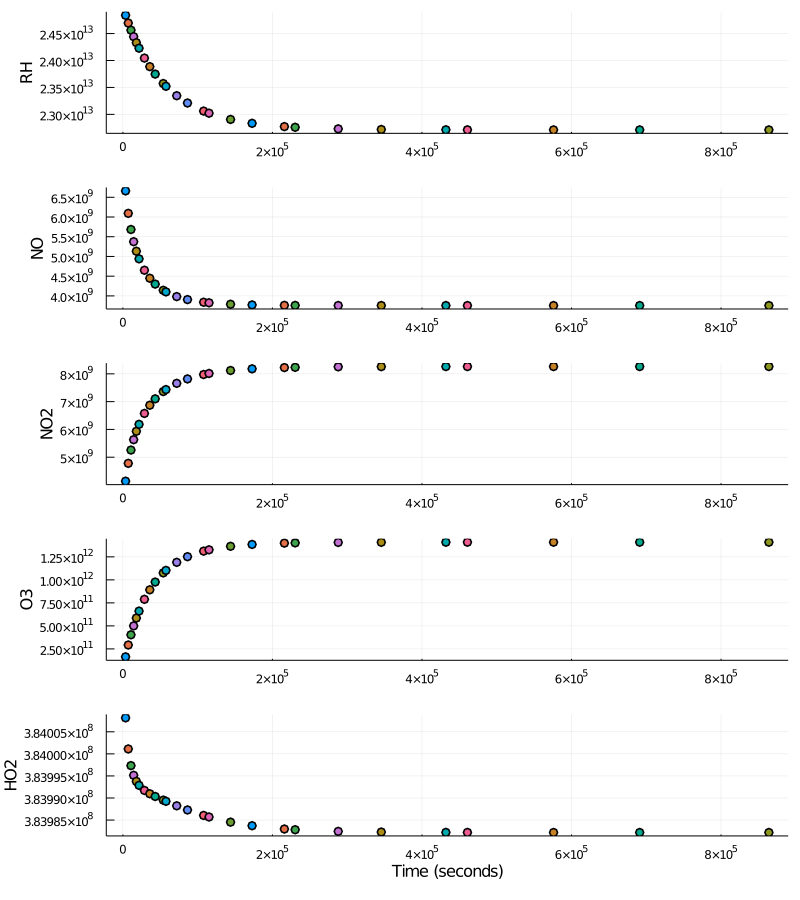

In [18]:
#Set up our species structs
NO2_species = Species(NO2_concentration, NO2_concentration_background, NO2_deposition_velocity, NO2_emissions) 
NO_species = Species(NO_concentration, NO_concentration_background, NO_deposition_velocity, NO_emissions) #molec/cm3 #molec/cm3 #cm/s #molec/cm2/s
RH_species = Species(RH_concentration, RH_concentration_background, RH_deposition_velocity, RH_emissions)
O3_species = Species(O3_concentration, O3_concentration_background, O3_deposition_velocity, O3_emissions)
HO2_species = Species(HO2_concentration, HO2_concentration_background, HO2_deposition_velocity, HO2_emissions)
species = Dict(
    "NO2"=>NO2_species,
    "NO"=>NO_species,
    "RH"=>RH_species, 
    "HO2"=>HO2_species, 
    "O3"=>O3_species)

#set up our box model struct
box = deepcopy(Box(H, Δx, Δx, u, species))

#plot the given parameters
p1 = plot(); p2 = plot(); p3 = plot(); p4 = plot(); p5 = plot();
p = plot(p1, p2, p3, p4, p5, layout=(5,1), size=(800, 900))
for t = 1:86400/Δt*days
    global prev_box = deepcopy(box)
    timestep!(box, Δt)
    if isnan(box.species["HO2"].concentration)
        print("Error--some of the concentrations are going to zero, make sure they are reasonable values")
    end
    if (t%(86400/t*days)) == 0
        plot!(p1,[t],[box.species["RH"].concentration],marker = :o, label = nothing, ylabel="RH")
        plot!(p2,[t],[box.species["NO"].concentration],marker = :o, label = nothing, ylabel="NO")
        plot!(p3,[t],[box.species["NO2"].concentration],marker = :o, label = nothing, ylabel="NO2")
        plot!(p4,[t],[box.species["O3"].concentration],marker = :o, label = nothing, ylabel="O3")
        plot!(p5,[t],[box.species["HO2"].concentration],marker = :o, label = nothing, ylabel="HO2", xlabel = "Time (seconds)")
    end
end
p
